In [75]:
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import NaiveBayes
from pgmpy.inference import VariableElimination

## Data reading

In [2]:
df = pd.read_csv('dataset/adult.data', na_values=[' ?'])
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,high-income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


## Data pre-processing

### Strip leading and trailing spaces from column names and cell values

In [4]:
df.columns = df.columns.str.strip()
for column in df.columns.values:
    if df[column].dtype == 'object':
        df[column] = df[column].str.strip()
df.columns.values

array(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'high-income'], dtype=object)

### Removing redundant or useless features

In [5]:
useless_features = ['fnlwgt', 'education-num']
df.drop(columns=useless_features, inplace=True)
df.columns.values

array(['age', 'workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'native-country', 'high-income'], dtype=object)

### Record variable names and the target variable (`high-income`)

In [6]:
variables_names = df.columns.values
target_variable = variables_names[-1]
feature_variables = variables_names[:-1]

### Checking for NA values

In [7]:
np.sum(pd.isnull(df), 0)

age                  0
workclass         1836
education            0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
high-income          0
dtype: int64

We can drop NA values, since they are only a few, w.r.t. the size of the dataset.

In [8]:
df = df.dropna()
np.sum(pd.isnull(df), 0)

age               0
workclass         0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
high-income       0
dtype: int64

### Binning continuos variables

In [9]:
def binning(column, bins_edges, categories=None, right=False):
    '''
    Bin the given pandas Series values into specific categories names associated 
    with numerical bins. If the categories list is not given, natural numbers 
    will be used as categories.
    '''
    if column.dtype == 'object':
        return column
    bins = [(bins_edges[i], bins_edges[i + 1]) for i in range(len(bins_edges) - 1)]
    if categories is None:
        categories = list(range(len(bins)))
    if len(categories) != len(bins):
        raise Exception(
            'The lenght of the bin edges list should be one element more than the lenght of the categories list.'
        )
    _categories = dict(zip(bins, categories))
    indices = np.digitize(column, bins=bins_edges, right=right)
    values = []
    for i in range(column.size):
        values.append(
            _categories[bins[indices[i] - 1]]
        )
    return pd.Series(values, index=column.index)

The `age` variable will be divided as follows:
* `age` < 18: `child`
* 18 <= `age` < 30: `young adult`
* 30 <= `age` < 60: `adult`
* `age` >= 60: `senior`

In [10]:
_age_bins_edges = [0, 18, 30, 60, 100]
_age_categories = ['child', 'young adult', 'adult', 'senior']
df['age'] = binning(column=df['age'].copy(), bins_edges=_age_bins_edges, categories=_age_categories)
df['age'].describe()

count     30162
unique        4
top       adult
freq      19296
Name: age, dtype: object

The `hours-per-week` variable will be divided as follows:
* `hours-per-week` < 25: `part time`
* 25 <= `hours-per-week` < 40: `full time`
* 40 <= `hours-per-week` < 60: `over time`
* `hours-per-week` >= 60: `too much time`

In [11]:
_hours_bins_edges = [0, 25, 40, 60, 100]
_hours_categories = ['part time', 'full time', 'over time', 'too much time']
df['hours-per-week'] = binning(column=df['hours-per-week'].copy(), bins_edges=_hours_bins_edges, categories=_hours_categories)
df['hours-per-week'].describe()

count         30162
unique            4
top       over time
freq          20991
Name: hours-per-week, dtype: object

### Discretizing other continuos variables

The `capital-gain` and `capital-loss` variables will be quantile-based discretized. 

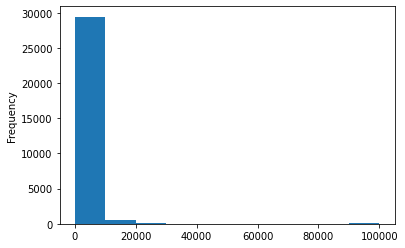

In [12]:
df['capital-gain'].plot(kind='hist')

In [13]:
df['capital-gain'], capital_gain_bins_edges = pd.qcut(df['capital-gain'], q=100, duplicates='drop', retbins=True)
df['capital-gain'].describe()

count                 30162
unique                    9
top       (-0.001, 2012.24]
freq                  27749
Name: capital-gain, dtype: object

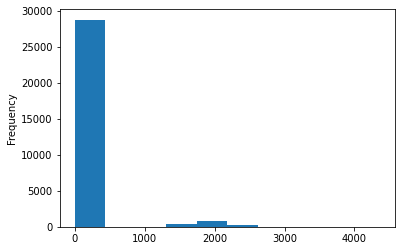

In [14]:
df['capital-loss'].plot(kind='hist')

In [15]:
df['capital-loss'], capital_loss_bins_edges = pd.qcut(df['capital-loss'], q=100, duplicates='drop', retbins=True)
df['capital-loss'].describe()

count                30162
unique                   5
top       (-0.001, 1590.0]
freq                 28963
Name: capital-loss, dtype: object

## Train/test split

In [16]:
mask = np.random.rand(len(df)) < 0.8
train = df[mask]
test = df[~mask]
print(f"Training set shape: {train.shape}")
print(f"Test set shape: {test.shape}")

Training set shape: (24047, 13)
Test set shape: (6115, 13)


## Prediction functions

In [76]:
def predict(data, inf, target_variable):
    '''
    Given a Dataframe, an inference object and a target variable,
    perform prediction and return the obtained results
    '''
    results = defaultdict(list)
    for _, data_point in predict_data.iterrows():
        if 'index' in data_point:
            del data_point['index']
        result = inf.query(
            variables=[target_variable],
            evidence=data_point.to_dict(),
            show_progress=False,
        )
        values = result.state_names[target_variable]
        for i, val in enumerate(values):
            results[val].append(result.values[i])
    return results

In [117]:
def accuracy(test_data, predicted_data):
    '''
    Return a percentage representing the classification accuracy
    over the test set
    '''
    predicted_column = []
    keys = list(predicted_data.keys())
    for val in zip(*predicted_data.values()):
        max_index = np.argmax(val)
        predicted_column.append(keys[max_index])
    predicted_column = pd.Series(predicted_column, index=test_data.index)
    equality = predicted_column.eq(test_data)
    true_equality = equality[equality == True]
    return (len(true_equality) / len(test_data)) * 100

## Naive Bayes model

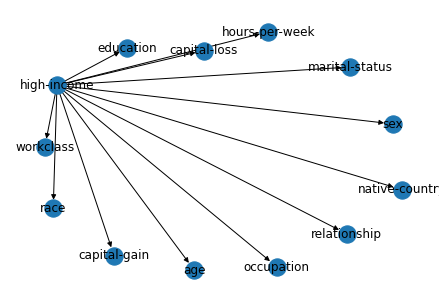

In [17]:
nb_model = NaiveBayes(
    feature_vars=feature_variables,
    dependent_var=target_variable
)
nx.draw(nb_model, with_labels=True)
plt.show()

### Estimate CPTs from data

In [18]:
nb_model.fit(train)
nb_cpds = nb_model.get_cpds()
for cpd in nb_cpds:
    print(cpd)

+------------------+---------------------+---------------------+
| high-income      | high-income(<=50K)  | high-income(>50K)   |
+------------------+---------------------+---------------------+
| age(adult)       | 0.5626000110357005  | 0.8669817690749494  |
+------------------+---------------------+---------------------+
| age(child)       | 0.01478783865805882 | 0.0                 |
+------------------+---------------------+---------------------+
| age(senior)      | 0.067704022512829   | 0.06920999324780554 |
+------------------+---------------------+---------------------+
| age(young adult) | 0.3549081277934117  | 0.06380823767724511 |
+------------------+---------------------+---------------------+
+----------------------------------+------------------------+----------------------+
| high-income                      | high-income(<=50K)     | high-income(>50K)    |
+----------------------------------+------------------------+----------------------+
| capital-gain((-0.001, 2012.2

In [19]:
nb_model.check_model()

True

### Prediction on test data

In [79]:
%%time
predict_data = test.copy().drop(target_variable, axis=1).reset_index()
nb_inference = VariableElimination(nb_model)
results = predict(predict_data, nb_inference, target_variable)
mean_results = {}
for k, v in results.items():
    mean_results[k] = np.mean(v)
print(mean_results)

{'<=50K': 0.6753066392890199, '>50K': 0.32469336071098015}
CPU times: user 1min 47s, sys: 819 ms, total: 1min 48s
Wall time: 1min 48s


In [122]:
nb_accuracy = accuracy(test[target_variable], results)
print(f'The Naive Bayes model has {round(nb_accuracy, 3)} % accuracy over the test set')

The Naive Bayes model has 80.605 % accuracy over the test set
